In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import PolynomialFeatures
from matplotlib import cm
import math
import matplotlib.patches as mpatches
import sys
import copy
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing

In [160]:
 class ScatterData:
    def __init__(self,x,y,color,label,marker,alpha):
        self.x = x
        self.y = y
        self.color = color
        self.label = label
        self.marker = marker
        self.alpha = alpha
class PlotData:
    def __init__(self,x,y,color,label,alpha):
        self.x = x
        self.y = y
        self.color = color
        self.label = label
        self.alpha = alpha
class HistogramData:
    def __init__(self,data,numBins):
        self.data = data
        self.numBins = numBins

In [161]:
 def PlotHelper(title, xLabel, yLabel, scatterData = None, plotData = None, histogramData = None):
    fig = plt.figure()
    ax= plt.axes()
    ax.set_xlabel(xLabel)
    ax.set_ylabel(yLabel)
    ax.set_title(title, loc='left')
    
    #(self,x,y,color,label,marker,alpha):
    if scatterData is not None:
        for data in scatterData:
            ax.scatter(data.x,data.y, label = data.label, color=data.color, alpha = data.alpha, marker =data.marker)
    
    if plotData is not None:
        for data in plotData:
            ax.plot(data.x,data.y, label = data.label, color=data.color, alpha = data.alpha)
    
    if histogramData is not None:
        plt.hist(histogramData.data, bins=histogramData.numBins)
            
    plt.legend()
    plt.show()

In [162]:
 def MeanSquareErrorPlot(title, xLabel, xVals, mse, std):
    fig = plt.figure() 
    ax = plt.axes()
    ax.set_title(title)
    plt.xlabel(xLabel)
    plt.ylabel("Mean Squared Error")   
    plt.errorbar(xVals, mse, yerr=std)
    plt.show()

In [163]:
class Dataset:
    def __init__(self, file,splitPercentage = .9, Debug = False):
        df = pd.read_json(file)
        if Debug:
            print(df.head())
            print(df.info())
        
        numRowsTrain = int(splitPercentage * df.shape[0])
        numRowsValidate = df.shape[0] - numRowsTrain
        #https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows
        df = shuffle(df, random_state = 0)
        df.reset_index(inplace=True, drop=True)
        self.X = df.iloc[:,1:]
        self.y = df.iloc[:,0]
        self.ColumnNames = df.columns[1:]
        # https://scikit-learn.org/stable/modules/preprocessing.html
        scaler = preprocessing.StandardScaler().fit(self.X)
        self.XScaled = scaler.transform(self.X)
        
        self.trainX = self.X.iloc[:numRowsTrain]
        self.validateX = self.X.iloc[numRowsTrain:]
        
        self.trainXScaled = scaler.transform(self.trainX)
        self.validateXScaled = scaler.transform(self.validateX)
        
        self.trainY = self.y.iloc[:numRowsTrain]
        self.validateY = self.y.iloc[numRowsTrain:]
        
        self.xPolys = {}
        self.xPolysScaled = {}
        self.trainxPolys= {}
        self.trainxPolysScaled = {}
        self.validatexPolys = {}
        self.validatexPolysScaled = {}
        self.polynomialFeatureNames = {}
    def AddPolynomialFeatures(self, degree):
        pf = PolynomialFeatures(degree)
        self.xPolys[degree] = pf.fit_transform(self.X)
        self.xPolysScaled[degree] = pf.fit_transform(self.XScaled)
        self.trainxPolys[degree] = pf.fit_transform(self.trainX)
        self.trainxPolysScaled[degree] = pf.fit_transform(self.trainXScaled)
        self.validatexPolys[degree] = pf.fit_transform(self.validateX)
        self.validatexPolysScaled[degree] = pf.fit_transform(self.validateXScaled)
        
        self.polynomialFeatureNames[degree] = pf.get_feature_names_out(self.ColumnNames)
    def PrintColumns(self):
        for name in self.ColumnNames:
            print(name)

In [189]:
class MLModel:
    def __init__(self):
        self.thetas = []
        self.type = None
        self.yPred = None
        self.model = None
    def TrainModel(self, ModelType, x, y, c = None, K = None):
        assert(self.type == None and ModelType in ["Lasso", "Ridge", "KNN"])
        self.type = ModelType
        if ModelType == "Lasso":
            self.model = linear_model.Lasso(alpha=(1/(2 * c)))
        elif ModelType == "Ridge":
            self.model = linear_model.Ridge(alpha=(1/(2 * c)))
        elif ModelType == "KNN":
            self.model = KNeighborsRegressor(n_neighbors = K)
            #assert (False)
        print("Fitting " + self.type)
        self.model.fit(x, y)
        
        if ModelType in ["Lasso", "Ridge"]:
            self.thetas.append(self.model.intercept_)
            for data in self.model.coef_:
                self.thetas.append(data)

    def KFoldsValidation(self, ModelType, x, y, hyperparameter = None, folds = 5):
        kf = KFold(n_splits = folds)
        assert(self.type == None and ModelType in ["Lasso", "Ridge", "KNN"])
        self.type = ModelType
        self.meanError = []
        self.stdError = []
        # Use current polynomial features and 
        # C value to perform k folds validation
        if ModelType == "Lasso":
            self.model = linear_model.Lasso(alpha=(1/(2 * hyperparameter)))
        elif ModelType == "Ridge":
            self.model = linear_model.Ridge(alpha=(1/(2 * hyperparameter)))
        elif ModelType == "KNN":
            return self.KFoldsKNN(x,y,hyperparameter, folds)
            
        
        temp = []
        for train,test in kf.split(x):
            self.model.fit(x[train], y[train])
            yPred = self.model.predict(x[test])
            # append the F1 Score for the currently trained model
            temp.append(mean_squared_error(y[test],yPred))
        
        self.meanError = np.array(temp).mean()
        self.stdError = np.array(temp).std()
        return self.meanError, self.stdError
    
    def KFoldsKNN(self, x, y, K, folds = 5):
        kf = KFold(n_splits = folds)
        self.model = KNeighborsRegressor(n_neighbors = K)
        self.meanError = []
        self.stdError = []

        temp = []
        for train,test in kf.split(x):
            self.model.fit(x[train], y[train])
            yPred = self.model.predict(x[test])
            
            temp.append(mean_squared_error(y[test],yPred))
        
        self.meanError = np.array(temp).mean()
        self.stdError = np.array(temp).std()
        return self.meanError, self.stdError
    def Predict(self, x, y):
        assert self.type != None
        yPred = self.model.predict(x)
        mse = mean_squared_error(y,yPred)
        return mse
    
    def PrintWeights(self, names):
        assert(self.type in ["Lasso", "Ridge"])
        weights = self.thetas[1:]
        print(len(names), len(weights))
        for i in range(len(weights)):
            print(names[i], weights[i])

In [190]:
dataset = Dataset("./scrubbed.json")

In [191]:
# Qs = [1,2,3,4,5]
Qs = [1,2,3]
for q in Qs:
    dataset.AddPolynomialFeatures(q)
dataset.trainY.mean()
dataset.trainX

,assists,deaths,denies,gold,gold_per_min,gold_spent,hero_damage,hero_healing,kills,last_hits,...,net_worth,tower_damage,xp_per_min,total_gold,total_xp,kda,kills_per_min,Last_Hits_Per_Minraw,Hero_Damage_Per_Minraw,Hero_Healing_Per_Minraw
0,16,4,5,767,307,7905,11745,1341,3,35,...,7622,934,509,7946,13174,3,0.115905,1.352221,453.76690,51.809402
1,0,3,0,3553,361,1490,3300,0,1,4,...,4778,0,177,4410,2162,0,0.081855,0.327422,270.12277,0.000000
2,12,12,4,346,278,7125,12602,7005,0,49,...,5696,147,250,8451,7600,0,0.000000,1.611842,414.53946,230.427630
3,8,5,4,1172,505,14390,6084,2063,3,199,...,14297,1974,672,15604,20764,1,0.097087,6.440129,196.89320,66.763756
4,21,9,1,2124,334,7660,12011,2374,5,54,...,8829,1220,483,11027,15947,2,0.151439,1.635538,363.78598,71.903076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11785,8,8,10,57,329,10995,16871,0,6,60,...,10387,0,518,11350,17871,1,0.173913,1.739130,489.01450,0.000000
11786,3,2,10,1871,401,9260,7431,231,2,192,...,10301,2494,526,10639,13956,1,0.075377,7.236181,280.06280,8.706030
11787,7,9,4,1099,405,9920,19038,0,0,155,...,10629,1912,509,12723,15991,0,0.000000,4.933687,605.98410,0.000000
11788,5,1,8,4784,526,9585,7142,0,3,145,...,13109,14415,534,13132,13332,4,0.120160,5.807743,286.06140,0.000000


In [167]:
len(dataset.polynomialFeatureNames[3])

2024

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


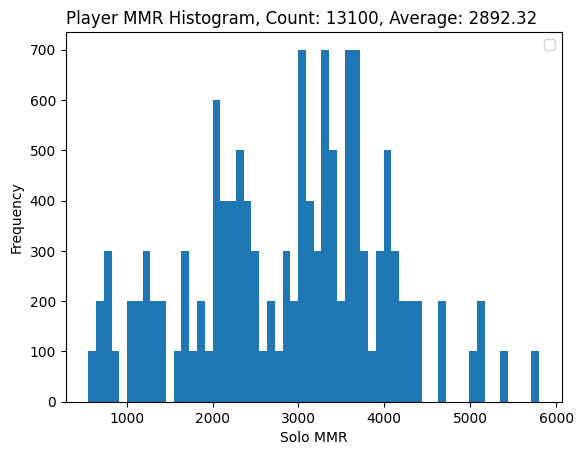

In [101]:
PlotHelper("Player MMR Histogram, Count: " + str(len(dataset.y)) + ", Average: " + str(round(np.average(dataset.y),2)), "Solo MMR", "Frequency", histogramData = HistogramData(dataset.y, max(dataset.y)//100))

In [143]:

CVals = [0.01,0.1,1,10,100,1000]
KVals = np.arange(1,101,2)
ModelTypes = ["Lasso", "Ridge", "KNN"]
# ModelTypes = ["KNN"]

Lasso Q = 1


C:\Users\mradt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.410e+08, tolerance: 1.157e+06
  model = cd_fast.enet_coordinate_descent(
C:\Users\mradt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.063e+08, tolerance: 1.167e+06
  model = cd_fast.enet_coordinate_descent(
C:\Users\mradt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

Lasso Q = 2


C:\Users\mradt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.233e+08, tolerance: 1.157e+06
  model = cd_fast.enet_coordinate_descent(
C:\Users\mradt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.379e+08, tolerance: 1.167e+06
  model = cd_fast.enet_coordinate_descent(
C:\Users\mradt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

Lasso Q = 3


C:\Users\mradt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.217e+08, tolerance: 1.157e+06
  model = cd_fast.enet_coordinate_descent(
C:\Users\mradt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.222e+08, tolerance: 1.167e+06
  model = cd_fast.enet_coordinate_descent(
C:\Users\mradt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

Lasso Q = 4


C:\Users\mradt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.853e+08, tolerance: 1.157e+06
  model = cd_fast.enet_coordinate_descent(
C:\Users\mradt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.856e+08, tolerance: 1.167e+06
  model = cd_fast.enet_coordinate_descent(
C:\Users\mradt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

Lasso Q = 5


C:\Users\mradt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.821e+08, tolerance: 1.157e+06
  model = cd_fast.enet_coordinate_descent(
C:\Users\mradt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.851e+08, tolerance: 1.167e+06
  model = cd_fast.enet_coordinate_descent(
C:\Users\mradt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

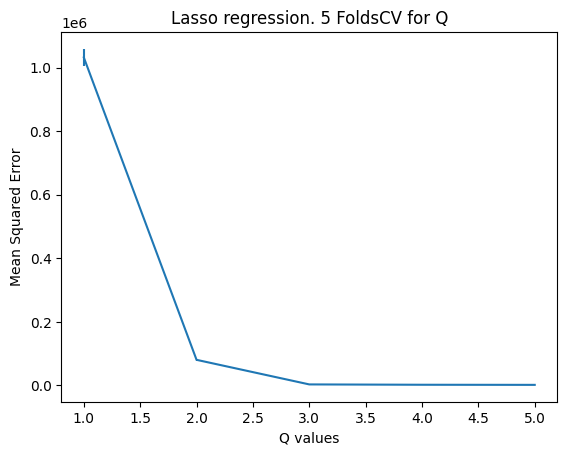

Ridge Q = 1
Ridge Q = 2
Ridge Q = 3
Ridge Q = 4
Ridge Q = 5


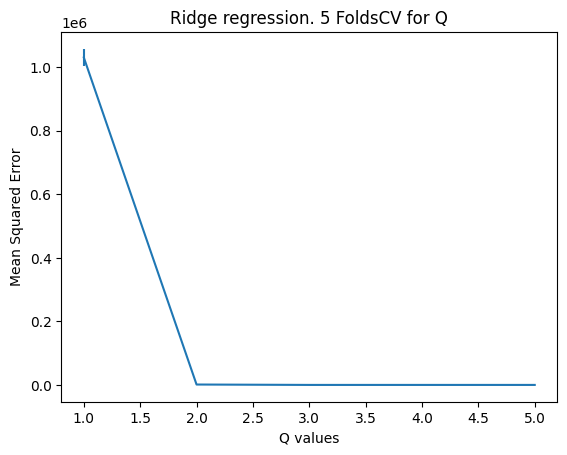

K = 1
K = 3
K = 5
K = 7
K = 9
K = 11
K = 13
K = 15
K = 17
K = 19
K = 21
K = 23
K = 25
K = 27
K = 29
K = 31
K = 33
K = 35
K = 37
K = 39
K = 41
K = 43
K = 45
K = 47
K = 49
K = 51
K = 53
K = 55
K = 57
K = 59
K = 61
K = 63
K = 65
K = 67
K = 69
K = 71
K = 73
K = 75
K = 77
K = 79
K = 81
K = 83
K = 85
K = 87
K = 89
K = 91
K = 93
K = 95
K = 97
K = 99


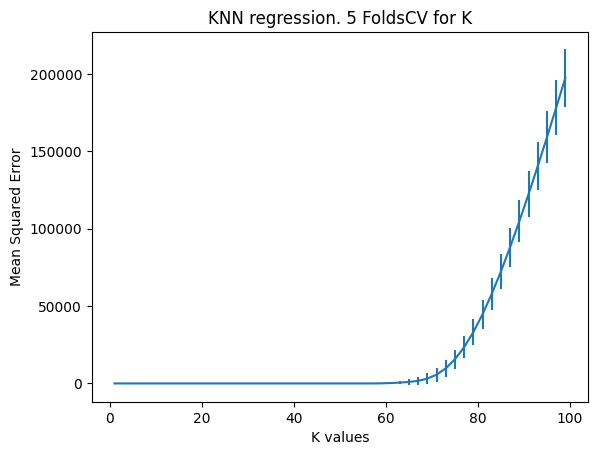

In [11]:
Models = []
defaultC = 1
# choose q then choose c
for mType in ModelTypes:
    mse = []
    std = []
    hyperparameterLabel = ""
    hyperparameterList = []
    if mType == "KNN":
        hyperparameterLabel = "K"
        hyperparameterList = KVals
        for k in KVals:
            print("K =",k)
            m = MLModel()
            x = dataset.trainXScaled
            y = dataset.trainY
            currMSE, currSTD = m.KFoldsValidation(mType,x,y,k)
            mse.append(currMSE)
            std.append(currSTD)
            Models.append(m)
    else:
        hyperparameterLabel = "Q"
        hyperparameterList = Qs
        for q in dataset.trainxPolys:
            print(mType, "Q =", q)
            m = MLModel()
            x = dataset.trainxPolysScaled[q]
            y = dataset.trainY
            currMSE, currSTD = m.KFoldsValidation(mType,x,y,defaultC)
            mse.append(currMSE)
            std.append(currSTD)
            Models.append(m)
            
    MeanSquareErrorPlot(mType + " regression. 5 FoldsCV for " + hyperparameterLabel, hyperparameterLabel + " values", hyperparameterList, mse, std)

In [12]:
for model in Models:
    print(model.type,model.meanError,model.stdError)

Lasso 1031539.5180325914 26913.90860663426
Lasso 80496.76193395161 3479.355917070216
Lasso 3159.0502859508733 235.67986940299895
Lasso 2092.276969319666 180.5567025762161
Lasso 1746.616643866831 177.056652516613
Ridge 1030516.2573578745 27049.292378394974
Ridge 1253.152944543726 73.88360152452246
Ridge 0.40670389368170384 0.03494866503920087
Ridge 0.02216208876950049 0.003114539781682204
Ridge 0.006077396223405284 0.0010554402235921684
KNN 0.0 0.0
KNN 0.0 0.0
KNN 0.0 0.0
KNN 0.0 0.0
KNN 0.0 0.0
KNN 0.0 0.0
KNN 0.0 0.0
KNN 0.0 0.0
KNN 0.0 0.0
KNN 0.0 0.0
KNN 0.0 0.0
KNN 0.0 0.0
KNN 0.0 0.0
KNN 0.0 0.0
KNN 0.0 0.0
KNN 0.0 0.0
KNN 0.0 0.0
KNN 0.0 0.0
KNN 0.0 0.0
KNN 0.0 0.0
KNN 0.0 0.0
KNN 0.0 0.0
KNN 0.0 0.0
KNN 0.0 0.0
KNN 0.0 0.0
KNN 0.0 0.0
KNN 0.0 0.0
KNN 0.0 0.0
KNN 0.0 0.0
KNN 65.56481215487253 131.12962430974505
KNN 246.68539123818476 490.0237640693677
KNN 533.1739074733342 1036.2534496666055
KNN 949.4262010228309 1767.2244542349094
KNN 1667.7890003856378 2632.0087507162607
KNN 30

Lasso C = 0.001
Lasso C = 0.01


C:\Users\mradt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.714e+06, tolerance: 1.172e+06
  model = cd_fast.enet_coordinate_descent(


Lasso C = 0.1


C:\Users\mradt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.525e+08, tolerance: 1.157e+06
  model = cd_fast.enet_coordinate_descent(
C:\Users\mradt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.115e+08, tolerance: 1.167e+06
  model = cd_fast.enet_coordinate_descent(
C:\Users\mradt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

Lasso C = 1


C:\Users\mradt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.217e+08, tolerance: 1.157e+06
  model = cd_fast.enet_coordinate_descent(
C:\Users\mradt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.222e+08, tolerance: 1.167e+06
  model = cd_fast.enet_coordinate_descent(
C:\Users\mradt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

Lasso C = 10


C:\Users\mradt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.261e+07, tolerance: 1.157e+06
  model = cd_fast.enet_coordinate_descent(
C:\Users\mradt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.240e+07, tolerance: 1.167e+06
  model = cd_fast.enet_coordinate_descent(
C:\Users\mradt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

Lasso C = 100


C:\Users\mradt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.952e+06, tolerance: 1.157e+06
  model = cd_fast.enet_coordinate_descent(
C:\Users\mradt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.910e+06, tolerance: 1.167e+06
  model = cd_fast.enet_coordinate_descent(
C:\Users\mradt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

Lasso C = 1000


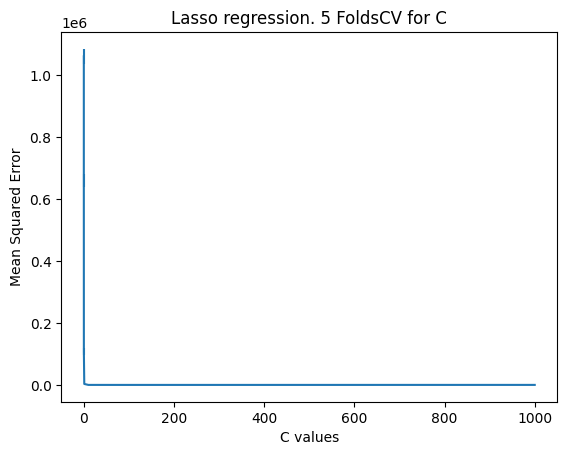

Ridge C = 0.001
Ridge C = 0.01
Ridge C = 0.1
Ridge C = 1
Ridge C = 10
Ridge C = 100
Ridge C = 1000


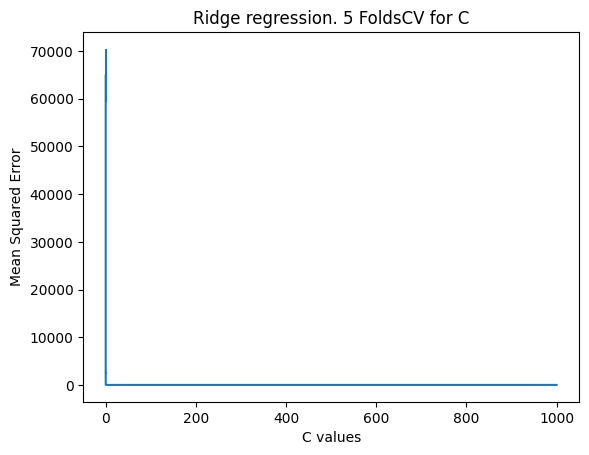

In [16]:
idealQ = 3
ModelsCV = []
ModelTypes = ["Lasso", "Ridge"]
Cs = [0.001,0.01,0.1,1,10,100,1000]
for mType in ModelTypes:
    mse = []
    std = []
    hyperparameterLabel = "C"
    hyperparameterList = Cs
    for c in Cs:
        print(mType, "C =", c)
        m = MLModel()
        x = dataset.trainxPolysScaled[idealQ]
        y = dataset.trainY
        currMSE, currSTD = m.KFoldsValidation(mType,x,y,c)
        mse.append(currMSE)
        std.append(currSTD)
        ModelsCV.append(m)
    MeanSquareErrorPlot(mType + " regression. 5 FoldsCV for " + hyperparameterLabel, hyperparameterLabel + " values", hyperparameterList, mse, std)

In [17]:
for model in ModelsCV:
    print(model.type,model.meanError,model.stdError)

Lasso 1060975.3170727678 23998.51325544573
Lasso 661249.1524125049 21116.275733963572
Lasso 107313.35379972434 10657.400046040904
Lasso 3159.0502859508733 235.67986940299895
Lasso 74.2281664459796 7.440412726812793
Lasso 15.986465816913597 3.6283925308645704
Lasso 87.52560411307854 12.426461334644607
Ridge 64844.99482155762 5597.669836789601
Ridge 2535.1694648018374 217.07252853636265
Ridge 38.004229873699714 3.217606868624946
Ridge 0.40670389368170384 0.03494866503920087
Ridge 0.004096932770195189 0.0003527594688859355
Ridge 4.099958591666177e-05 3.5309262712990272e-06
Ridge 4.100261698953199e-07 3.531262396598482e-08


In [194]:
idealQ = 3
idealLassoC = 10
idealRidgeC = 0.1
idealK = 59

LassoX = dataset.trainxPolysScaled[idealQ]
RidgeX = dataset.trainxPolysScaled[idealQ]
KNNX = dataset.trainXScaled

In [169]:
Lasso = MLModel()
Lasso.TrainModel("Lasso", LassoX, dataset.trainY, c = idealLassoC)
print("Lasso MSE", Lasso.Predict(dataset.validatexPolysScaled[idealQ], dataset.validateY))

Fitting Lasso
Lasso MSE 61.610486877293035


C:\Users\mradt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.332e+07, tolerance: 1.456e+06
  model = cd_fast.enet_coordinate_descent(


In [196]:
Ridge = MLModel()
Ridge.TrainModel("Ridge", RidgeX, dataset.trainY, c = idealRidgeC)
print("Ridge MSE", Ridge.Predict(dataset.validatexPolysScaled[idealQ], dataset.validateY))

Fitting Ridge
Ridge MSE 21.11663611121992


In [206]:
KNN = MLModel()
print(idealK)
KNN.TrainModel("KNN", KNNX, dataset.trainY, K = idealK)
print("KNN MSE", mean_squared_error(KNN.model.predict(dataset.validateXScaled), dataset.validateY))

59
Fitting KNN
KNN MSE 0.0


In [213]:
for i, prediction in enumerate(KNN.model.predict(dataset.validateXScaled)):
    print(prediction, dataset.validateY.to_numpy()[i])

1007.0 1007
3291.0 3291
2078.0 2078
2357.0 2357
2286.0 2286
3119.0 3119
2000.0 2000
2742.0 2742
3145.0 3145
3092.0 3092
2274.0 2274
3711.0 3711
4412.0 4412
3072.0 3072
3727.0 3727
3656.0 3656
1195.0 1195
1338.0 1338
2357.0 2357
2274.0 2274
666.0 666
2357.0 2357
3585.0 3585
3119.0 3119
3662.0 3662
3987.0 3987
3626.0 3626
2426.0 2426
3671.0 3671
4180.0 4180
3917.0 3917
3579.0 3579
3917.0 3917
2004.0 2004
5075.0 5075
1768.0 1768
2399.0 2399
3119.0 3119
3987.0 3987
1043.0 1043
553.0 553
3020.0 3020
3987.0 3987
3072.0 3072
3430.0 3430
2426.0 2426
4128.0 4128
3626.0 3626
1443.0 1443
2078.0 2078
2082.0 2082
3965.0 3965
2286.0 2286
5802.0 5802
2521.0 2521
3272.0 3272
890.0 890
742.0 742
3322.0 3322
553.0 553
3550.0 3550
2202.0 2202
3876.0 3876
1654.0 1654
2005.0 2005
2937.0 2937
3072.0 3072
4412.0 4412
3017.0 3017
3294.0 3294
3145.0 3145
4307.0 4307
3436.0 3436
3272.0 3272
3072.0 3072
2094.0 2094
2099.0 2099
2055.0 2055
2365.0 2365
3721.0 3721
3615.0 3615
809.0 809
1636.0 1636
4283.0 4283
1189

In [172]:
Ridge.PrintWeights(dataset.polynomialFeatureNames[idealQ])

2024 2024
1 0.0
assists -160.75846839375032
deaths -196.78907172986737
denies -151.48862070555253
gold -34.22418556219213
gold_per_min -28.590224425224868
gold_spent 79.3344843641854
hero_damage 214.36885065859903
hero_healing -86.00164903600691
kills -84.6699411968798
last_hits 188.24603590683947
level 113.68137599602541
net_worth 139.80421011450463
tower_damage 26.11658428270573
xp_per_min -11.901953106044994
total_gold 41.87650127775407
total_xp 71.0715137345558
kda 5.056469948913378
kills_per_min -124.25554239859238
Last_Hits_Per_Minraw 174.2426144697124
Hero_Damage_Per_Minraw 184.11360556391443
Hero_Healing_Per_Minraw -119.96333898889763
assists^2 -158.32766181771856
assists deaths 148.82861217273282
assists denies -13.11172300670738
assists gold -219.75800270695606
assists gold_per_min 19.81073205706517
assists gold_spent -4.080589763417968
assists hero_damage 32.52339493833859
assists hero_healing 39.09484257773803
assists kills -5.060216963872135
assists last_hits 144.348937031

In [178]:
pairs = list(zip(Ridge.thetas[1:], dataset.polynomialFeatureNames[idealQ]))
pairs.sort(key=lambda a: a[0])
for pair in pairs:
    print(pair)

(-237.12712532481328, 'assists gold^2')
(-219.75800270695606, 'assists gold')
(-196.78907172986737, 'deaths')
(-184.26800630475267, 'last_hits tower_damage')
(-184.07149109109054, 'assists^2 hero_damage')
(-180.36936882810485, 'tower_damage Last_Hits_Per_Minraw')
(-180.21800149348323, 'assists^2 Hero_Damage_Per_Minraw')
(-160.75846839375032, 'assists')
(-158.9099099039905, 'deaths level')
(-158.32766181771856, 'assists^2')
(-154.3046615606019, 'kills last_hits^2')
(-151.48862070555253, 'denies')
(-151.06327460864009, 'last_hits^2 kills_per_min')
(-149.7807979443445, 'deaths total_xp')
(-143.94710773430666, 'assists deaths gold_per_min')
(-143.74980728052063, 'xp_per_min Hero_Damage_Per_Minraw')
(-143.6586812970005, 'net_worth tower_damage')
(-135.8971240816002, 'gold last_hits')
(-134.28727194335116, 'denies gold total_gold')
(-131.8598867978141, 'deaths total_xp^2')
(-131.28651350152182, 'deaths level total_xp')
(-131.16485042316344, 'gold hero_healing kills_per_min')
(-126.4375291185

In [179]:
pairs = list(zip(Lasso.thetas[1:], dataset.polynomialFeatureNames[idealQ]))
pairs.sort(key=lambda a: a[0])
for pair in pairs:
    print(pair)

(-580.3232925221104, 'deaths level')
(-521.4380764401624, 'kills')
(-470.70814546978824, 'assists deaths denies')
(-395.322376637121, 'deaths gold level')
(-384.67683008183764, 'assists deaths total_gold')
(-360.7795217016031, 'gold_per_min hero_healing total_gold')
(-340.90379126851616, 'assists^2 Hero_Damage_Per_Minraw')
(-336.8820807439684, 'assists net_worth^2')
(-332.78852151996244, 'assists kills_per_min')
(-330.3566411320797, 'deaths')
(-319.5599148083181, 'assists gold kills')
(-318.6960954610341, 'denies hero_healing total_gold')
(-313.40297190367784, 'deaths denies')
(-312.17938164604516, 'gold_per_min total_gold Hero_Healing_Per_Minraw')
(-306.70539318149633, 'tower_damage')
(-305.54977109749643, 'gold_per_min hero_damage hero_healing')
(-301.1944206742718, 'hero_damage hero_healing')
(-297.71627965567734, 'deaths gold')
(-291.1247466357191, 'gold total_gold Hero_Healing_Per_Minraw')
(-278.2405049354064, 'assists^2')
(-277.9678133324952, 'deaths last_hits Hero_Healing_Per_Mi

In [181]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
dummy = DummyRegressor(strategy="mean").fit(dataset.trainX, dataset.trainY)
dummyPred = dummy.predict(dataset.validateX)
print("Mean squared error: " + str((mean_squared_error(dataset.validateY,dummyPred))))

Mean squared error: 1205977.7391530825
